In [1]:
import trig_poly
import dual_certificates
import test_data
import numpy as np
import plt_util
import phase_transition
from matplotlib import pyplot as plt

%matplotlib inline

# Solution of Linear System

In [150]:
def diag_vec_indices(k):
    """Returns indices of diagonal entries when a matrix is vectorized."""
    return [i * k + i for i in range(k)]

In [233]:
reload(test_data)
reload(dual_certificates)
reload(trig_poly)

m = 10
fc = 50
min_separation = 0.65 / fc
N = int(1.0/min_separation-1)

kernel = trig_poly.TrigPoly.dirichlet(fc)

support = test_data.jittered_supports(N, min_separation=min_separation)
sign_pattern = test_data.uniform_sign_pattern_multidim(N, m)

In [234]:
support_differences = np.outer(np.ones(N), support) - np.outer(support, np.ones(N))

K0 = kernel.eval(support_differences)
K1 = kernel.derivative().eval(support_differences)
K2 = kernel.derivative().derivative().eval(support_differences)

In [235]:
A = np.bmat([
        [np.kron(np.identity(m), K0), np.kron(sign_pattern.T, K1)[:, diag_vec_indices(N)]],
        [np.kron(sign_pattern.conj(), K1)[diag_vec_indices(N), :], np.kron(np.dot(sign_pattern.conj(), sign_pattern.T), K2)[diag_vec_indices(N), :][:, diag_vec_indices(N)]]
    ])
b = np.hstack([sign_pattern.flatten('F'), np.zeros(N)])

In [236]:
coeffs = np.linalg.solve(A, b)

alpha_flat = coeffs[:N * m]
alpha = alpha_flat.reshape((m, N)).T
beta = coeffs[N * m:]

interpolant = trig_poly.MultiTrigPoly(
    [kernel.sum_shifts(-support, alpha[:, k]) + 
     # TODO: Figure out why minus sign below is necessitated by K' being an odd function, hence K1 being antisymmetric
     kernel.derivative().sum_shifts(-support, -beta * sign_pattern[:, k]) for k in range(m)])

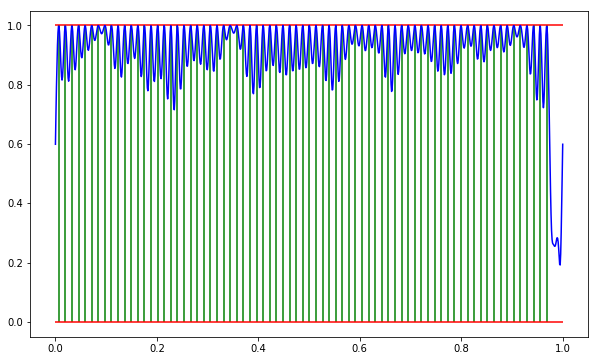

In [237]:
plt.subplots(figsize=(10, 6))

plt_util.plot_trig_poly_magnitude(interpolant)
plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds()

In [238]:
print dual_certificates.validate(support, sign_pattern, interpolant)

{'status': True, 'max_deviation': 7.7172440175568609e-14, 'values_achieved': True, 'bound_achieved': True}


In [239]:
interpolant_kernels = trig_poly.MultiTrigPoly(
    [kernel.sum_shifts(-support, alpha[:, k]) for k in range(m)])
interpolant_corrections = trig_poly.MultiTrigPoly(
    [kernel.derivative().sum_shifts(-support, -beta * sign_pattern[:, k]) for k in range(m)])

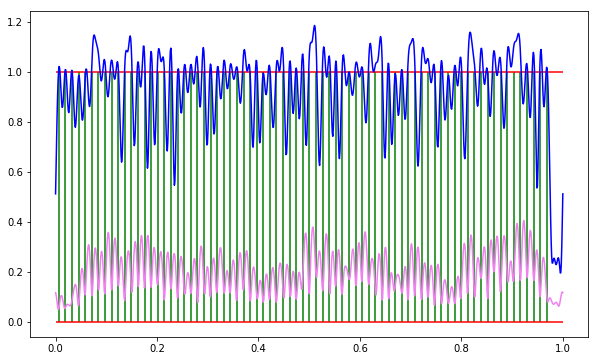

In [240]:
plt.subplots(figsize=(10, 6))

plt_util.plot_trig_poly_magnitude(interpolant_kernels, c='blue')
plt_util.plot_trig_poly_magnitude(interpolant_corrections, c='violet')

plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds()

# Exact Formulas for Coefficients

In [60]:
reload(test_data)
reload(dual_certificates)
reload(trig_poly)

m = 10
fc = 50
min_separation = 0.7 / fc
N = int(1.0/min_separation-1)

kernel = trig_poly.TrigPoly.dirichlet(fc)

support = test_data.jittered_supports(N, min_separation=min_separation)
sign_pattern = test_data.uniform_sign_pattern_multidim(N, m)

In [61]:
support_differences = np.outer(np.ones(N), support) - np.outer(support, np.ones(N))

K0 = kernel.eval(support_differences)
K1 = kernel.derivative().eval(support_differences)
K2 = kernel.derivative().derivative().eval(support_differences)

K0_inv = np.linalg.inv(K0)

V = sign_pattern
VVH = np.dot(sign_pattern, sign_pattern.conj().T)

In [62]:
beta = np.diag(np.dot(K0_inv, K1)) / np.diag(K2 - np.linalg.multi_dot([K1, K0_inv, K1]))
alpha = np.linalg.multi_dot([K0_inv, np.identity(N) - np.dot(K1, np.diag(beta)), V])

In [63]:
interpolant = trig_poly.MultiTrigPoly(
    [kernel.sum_shifts(-support, alpha[:, k]) + 
     kernel.derivative().sum_shifts(-support, np.dot(np.diag(beta), V)[:, k]) for k in range(m)])

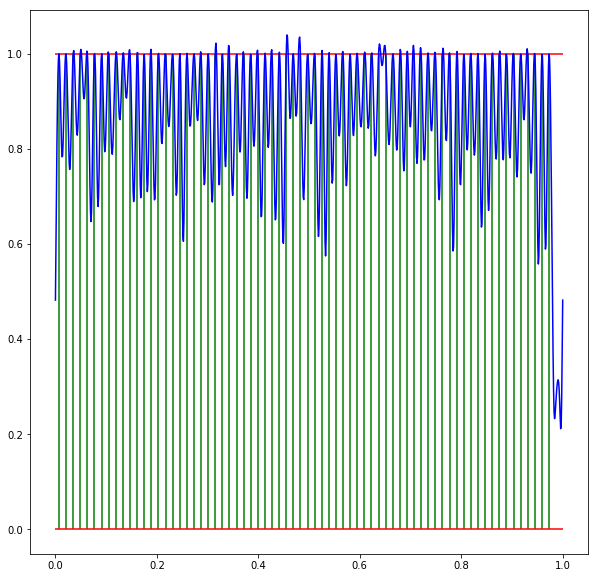

In [66]:
plt.subplots(figsize=(10, 10))

plt_util.plot_trig_poly_magnitude(interpolant)
plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds()

In [65]:
print dual_certificates.validate(support, sign_pattern, interpolant)

{'status': False, 'max_deviation': 0.0014890713480427476, 'values_achieved': False, 'bound_achieved': False}
